### Evaluating MMIDAS - Mouse smartseq data
This notebook guides you in evaluating MMIDAS in identifying meaningful cell types.

In [1]:
import warnings
import subprocess
import os
from os import path
import glob
import functools
from typing import Mapping, Any, Literal, Iterable, Sequence, Optional

import numpy as np
import torch as th
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import normalize
from tqdm import trange

def run_cmd(cmd: str) -> str:
    return subprocess.check_output(cmd, shell=True).decode().strip()

def get_parentdirname(d: str) -> str:
    return path.basename(path.dirname(d))

def is_childdir(d: str, c: str) -> bool:
    return c in os.listdir(d)

def fix_dir(d: str) -> None:
    if os.getcwd().endswith(d):
        pass
    elif get_parentdirname(os.getcwd()) == d:
        os.chdir('..')
    elif is_childdir(os.getcwd(), d):
        os.chdir(d)

def dedup(xs: Iterable) -> Iterable:
    acc = []
    seen = set()
    for x in xs:
        if x not in seen:
            acc.append(x)
        seen.add(x)
    return acc

def tree_reload() -> None:
    raise NotImplementedError

def unstable(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        warnings.warn(f"{func.__name__}() is unstable", category=FutureWarning,stacklevel=2)
        return func(*args, **kwargs)
    return wrapper

DIR = "distributed-vae" # warning: change this if you change the name of the directory

fix_dir(DIR)

In [2]:
import mmidas
from mmidas.nn_model import mixVAE_model
from mmidas.utils.tree_based_analysis import get_merged_types
from mmidas.cpl_mixvae import cpl_mixVAE, unwrap
from mmidas.utils.tools import get_paths
from mmidas.utils.dataloader import load_data, get_loaders
from mmidas.utils.cluster_analysis import K_selection
from mmidas.utils.dataloader import load_data
from mmidas.eval_models import summarize_inference

In [3]:
MouseSmartSeq =  Literal["mouse_smartseq"]
Mouse10x = Literal["TODO"]
SeattleAlzheimer = Literal["TODO"]

Dataset = MouseSmartSeq | Mouse10x | SeattleAlzheimer

dataset = 'mouse_smartseq'
config: Mapping[str, Any] = get_paths('pyproject.toml', dataset)
data: Mapping[str, Any] = load_data(config[dataset]['data_path'] / config[dataset]['anndata_file'])

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/pyproject.toml
Getting files directories belong to mouse_smartseq...


/home/hilal.mufti/miniforge3/envs/mdist-mmidas/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


data is loaded!
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes:5032


In [4]:
dedup(type(v) for v in data.values())

[numpy.matrix, numpy.ndarray, pandas.core.arrays.categorical.Categorical, int]

In [5]:
def get_trained_models(f: str) -> Sequence[str]:
    return glob.glob(f + '/model/cpl_mixVAE_model_before**')

trained_model_folder = config[dataset]['trained_model']
saving_folder = str(config['paths']['main_dir'] / config[dataset]['saving_path'] / trained_model_folder)
trained_models = get_trained_models(saving_folder)
selected_model = trained_models[0]
selected_model

'/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A3_B5000_E100000_Ep0_RUN0/model/cpl_mixVAE_model_before_pruning_A3_2024-09-02-21-27-30.pth'

##### Construct a cpl-mixVAE object and load the trained_model.

In [6]:
def mk_vae(C, state_dim, input_dim, device, eps=1e-8, fc_dim=100, latent_dim=10, x_drop=0.5, s_drop=0.2, lr=.001,
           lam=1, lam_pc=1, A=2, tau=0.005, beta=1., hard=False, variational=True, ref_prior=False,
           momentum=.01, mode='MSE') -> nn.Module:
    return mixVAE_model(input_dim=input_dim, fc_dim=fc_dim, n_categories=C, state_dim=state_dim,
                                lowD_dim=latent_dim, x_drop=x_drop, s_drop=s_drop, n_arm=A, lam=lam, lam_pc=lam_pc,
                                tau=tau, beta=beta, hard=hard, variational=variational, device=device, eps=eps,
                                ref_prior=ref_prior, momentum=momentum, loss_mode=mode).to(device)

def _mk_vae_cfg(A: int) -> Mapping[str, Any]:
    return {
        'C': 92,
        'state_dim': 2,
        'input_dim': data['log1p'].shape[1],
        'device': 'cuda',
        'A': A,
        'latent_dim': 10,
    }

mk_vae(**_mk_vae_cfg(5))

mixVAE_model(
  (x_dp): Dropout(p=0.5, inplace=False)
  (s_dp): Dropout(p=0.2, inplace=False)
  (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
  (elu): ELU(alpha=1.0)
  (tanh): Tanh()
  (fc1): ModuleList(
    (0-4): 5 x Linear(in_features=5032, out_features=100, bias=True)
  )
  (fc2): ModuleList(
    (0-4): 5 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc3): ModuleList(
    (0-4): 5 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc4): ModuleList(
    (0-4): 5 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc5): ModuleList(
    (0-4): 5 x Linear(in_features=100, out_features=10, bias=True)
  )
  (fcc): ModuleList(
    (0-4): 5 x Linear(in_features=10, out_features=92, bias=True)
  )
  (fc_mu): ModuleList(
    (0-4): 5 x Linear(in_features=102, out_features=2, bias=True)
  )
  (fc_sigma): ModuleList(
    (0-4): 5 x Linear(in_features=102, out_features=2, bias=True)
  )
  (fc6): ModuleList(
    (0-4): 5 x Linear(in_features=94, out_fe

In [7]:
# TODO: just parse the file name to get these params

n_categories = 92 # upper bound of number of categories (clusters)
state_dim = 2 # continuous (state) variable dimensionality 
n_arm = 3 # number of arms
latent_dim = 10 # latent dimensionality of the model
train_loader, test_loader, all_loader = get_loaders(dataset=data['log1p'], batch_size=5000, seed=546)

cplMixVAE = cpl_mixVAE(saving_folder=saving_folder, device='cpu')
cplMixVAE.init_model(n_categories=n_categories,
                     state_dim=state_dim,
                     input_dim=data['log1p'].shape[1],
                     lowD_dim=latent_dim,
                     n_arm=n_arm)
cplMixVAE.variational = False

C = n_categories
S = state_dim
A = n_arm
D_lat = latent_dim

using cpu


## Model selection

##### Determining the sub-optimal number of clusters by leveraging consensus values across multiple pruning runs.
If you do not employ the pruning algorithm to determine the number of clusters, you can skip the following step.

In [8]:
# Loading trained models including before pruning and after pruning
summary = summarize_inference(cplMixVAE, trained_models, train_loader)
summary.keys()

Model /cpl_mixVAE_model_before_pruning_A3_2024-09-02-21-27-30.pth


/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/cpl_mixvae.py:324: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_file = torch.load(tr

torch.Size([3, 5000, 92]) torch.Size([5000, 92])


RuntimeError: shape '[5000, 92]' is invalid for input of size 1380000

In [11]:
# Plotting average consensus measure to select the number of clusters according to the minimum consensus measure, here 0.95

summary_file = saving_folder + f'/summary_performance_K_{n_categories}_narm_{n_arm}.p'
with open(summary_file, 'rb') as f:
    summary_dict = np.load(f, allow_pickle=True)
f.close()

model_order = K_selection(summary_dict, n_categories, n_arm, thr=0.95)

FileNotFoundError: [Errno 2] No such file or directory: '/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E100000_Ep0_RUN0/summary_performance_K_92_narm_2.p'

Assessing the performance of the model for the chosen model order, which denotes the dimensionality of the categorical representation in the mixture VAE model.

In [9]:
# selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
model_order = n_categories
selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_before_**')[0]
outcome = summarize_inference(cplMixVAE, selected_model, train_loader)

Model /cpl_mixVAE_model_before_pruning_A3_2024-09-02-21-27-30.pth


In [11]:
Run = str | int
Config = Mapping[str, Any]
TrainedModelFile = str
Summary = Mapping[Any, Any]
Arm = int
Arms = int

Consensus = float
MI = float

TrainedModel = nn.Module

Bias = th.Tensor
PruningMask = th.Tensor | np.ndarray
PruningIndex = th.Tensor

MixVAE = mixVAE_model

def unwrap_literal(x: Dataset) -> str:
    return x.__args__[0]

def mk_run(arms: int, run: int) -> Run:
    return f"K92_S2_AUGTrue_LR0.001_A{arms}_B5000_E100000_Ep0_RUN{run}"

def mk_config(r: Run, d: Dataset) -> Config:
    config = get_paths('pyproject.toml', unwrap_literal(d))
    config['mouse_smartseq']['trained_model'] = r
    return config

def get_weights(r: Run, d: Dataset) -> TrainedModelFile: 
    c: Config = mk_config(r, d)
    saving_folder = c['paths']['main_dir'] / c[unwrap_literal(d)]['saving_path']
    trained_model_folder = c[unwrap_literal(d)]['trained_model']
    saving_folder = str(saving_folder / trained_model_folder)
    trained_models = glob.glob(saving_folder + '/model/cpl_mixVAE_model_before**')
    assert len(trained_models) == 1
    return trained_models[0]

def load_weights(m: nn.Module, f: str) -> None:
    m.load_state_dict(th.load(f, map_location='cpu')['model_state_dict'])

def run_to_model(r: Run, d: Dataset) -> nn.Module:
    f = get_weights(r, d)

def len_arms(m: nn.Module) -> int:
    return m.n_arm

def len_categories(m: nn.Module) -> int:
    return m.n_categories

def get_input_dim(m: nn.Module) -> int:
    return m.input_dim

def get_bias_discrete(m: nn.Module) -> Bias:
    return m.fcc[0].bias

def get_pruning_mask(m: nn.Module) -> PruningMask:
    return th.where(get_bias_discrete(m) != 0.)[0]

def get_pruning_index(m: nn.Module) -> PruningIndex:
    return th.where(get_bias_discrete(m) == 0.)[0]

# def summary_over_runs(arm1: tuple[Run, Arm], arm2: tuple[Run, Arm], d: Dataset) -> Summary:
#     m1, m2 = get_trained_model(arm1[0], d), get_trained_model(arm2[0], d)

#     return {}

def evals(m: MixVAE, dl: DataLoader) -> Summary:
    A = len_arms(m)
    B = unwrap(dl.batch_size)
    C = len_categories(m)
    D = get_input_dim(m)
    N = len(dl.dataset)
    temp = 1.
    dev = m.device
    
    m.eval()

    pruning_mask = get_pruning_mask(m)
    pruning_index = get_pruning_index(m)

    with th.no_grad():
        for i, (x, d_x) in enumerate(dl): # batch index, (data, data index)
            x = x.to(dev)
            d_x = d_x.to(int)

            start = i * B
            end = min((i + 1) * B, N)

            c_bin = 0.
            c_prior = 0.

            x_augs = [x for _ in range(A)]

            x_recs, p_xs, r_xs, x_lows, cs, ss, c_smps, s_means, s_logvars, _ = m(x_augs, temp, c_prior, mask=pruning_mask, eval=True)
            losses, loss_recs, _, _, dist_c, 
        

    return {
        'pruning_mask': pruning_mask,
        'pruning_index': pruning_index,
    }

def compute_summary(m: nn.Module, opt: optim.Optimizer, dl: DataLoader) -> Summary:
    A = len_arms(m)
    C = len_categories(m)

    return {}

def compare(a: tuple[nn.Module, Arm], b: tuple[nn.Module, Arm]) -> Summary:
    return {}

def plot_mi(s1: tuple[Summary, Arm], s2: tuple[Summary, Arm]) -> MI:
    pass

def plot_mi_heatmap(s1: tuple[Summary, Arm], s2: tuple[Summary, Arm]) -> MI:
    pass

evals(mk_vae(**_mk_vae_cfg(5)), train_loader)

NameError: name 'losses' is not defined

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:18<00:00,  4.90it/s]


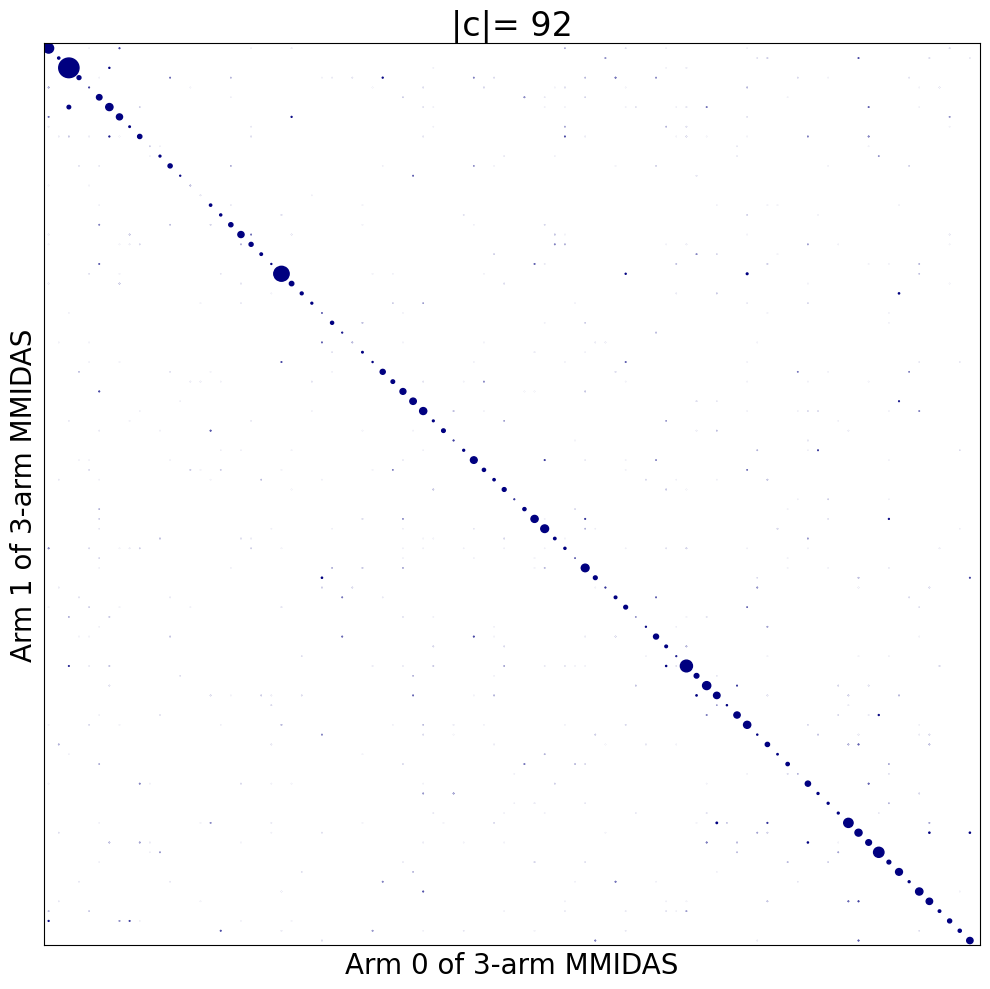

In [12]:
def get_axis(axes: tuple[Arm, Arms, Optional[Run]]) -> str:
    if axes[0] == 'ttypes' and axes[1] == 'ttypes':
        return 'Ttypes classification'
    elif axes[2]:
        return f'Arm {axes[0]} of {axes[1]}-arm MMIDAS, run {axes[2]}'
    else:
        return f'Arm {axes[0]} of {axes[1]}-arm MMIDAS'
    
def get_axis_save(axes: tuple[Arm, Arms, Optional[Run]]) -> str:
    if axes[0] == 'ttypes' and axes[1] == 'ttypes':
        return 'tt'
    elif axes[2]:
        return f'{axes[0]}{axes[1]}{axes[2]}'
    else:
        return f'{axes[0]}{axes[1]}'

def plot_consensus_circ(a_vs_b: np.ndarray, axes: tuple[tuple[Arms, Arm, Optional[Run]], tuple[Arms, Arm, Optional[Run]]], savedir: Optional[str]) -> None:
    assert a_vs_b.shape[0] == a_vs_b.shape[1]

    mtx = a_vs_b / np.max(a_vs_b) 
    C = mtx.shape[0] # number of clusters

    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    for l in trange(C):
        for col in range(C):
            axs.add_patch(plt.Circle(np.array([col, l]), radius=mtx[l, col], color='Navy'))
    axs.set_xlim([-.5, C])
    axs.set_ylim([-.5, C - .5])
    axs.invert_yaxis()
    axs.set_yticks([])
    axs.set_xticks([])
    axs.set_yticklabels([])
    axs.set_xticklabels([])
    plt.title('|c|= ' + str(a_vs_b.shape[0]), fontsize=24)
    axs.set_xlabel(get_axis(axes[0]), fontsize=20)
    axs.set_ylabel(get_axis(axes[1]), fontsize=20)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + f'/consensus_T{get_axis_save(axes[0])}_vs_T{get_axis_save(axes[1])}_K_{C}.png', dpi=600)

plot_consensus_circ(outcome['armA_vs_armB'][-1], ((0, 3, None), (1, 3, None)), saving_folder)

avg consensus on test cells: 0.6817725440741657


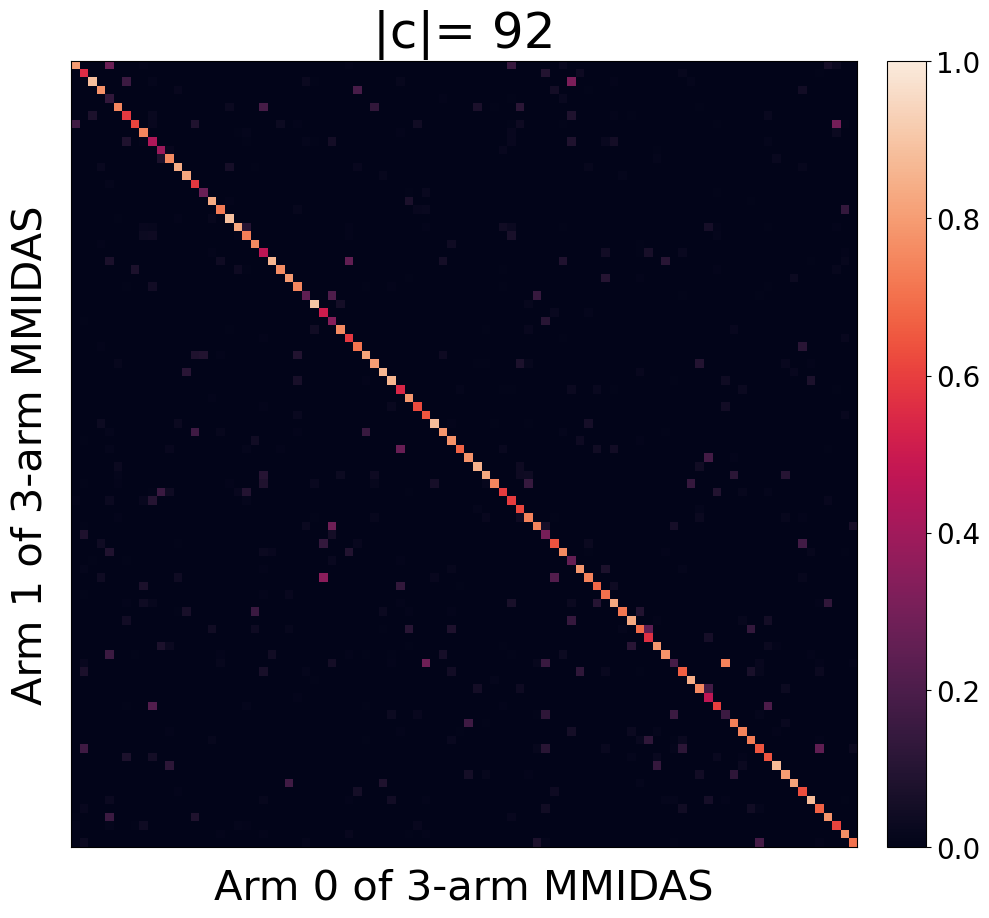

In [13]:
ConsensusMatrix = np.ndarray

def plot_consensus_heatmap(cm: ConsensusMatrix, axes: tuple[tuple[Arm, Arms, Optional[Run]], tuple[Arm, Arms, Optional[Run]]], savedir: Optional[str]) -> None:
     plt.figure(figsize=[10,10])
     ax = plt.gca()
     im = ax.imshow(cm, cmap='rocket', vmin=0, vmax=1)
     plt.xlabel(f"Arm {axes[0][0]} of {axes[0][1]}-arm MMIDAS", fontsize=30, labelpad=15)     
     plt.ylabel(f"Arm {axes[1][0]} of {axes[1][1]}-arm MMIDAS", fontsize=30, labelpad=15)
     plt.xticks([])
     plt.yticks([])
     plt.title('|c|= ' + str(cm.shape[0]), fontsize=36, pad=10)
     divider = make_axes_locatable(ax)
     cax = divider.append_axes("right", size="5%", pad=0.3)
     cbar = plt.colorbar(im, cax=cax)
     for t in cbar.ax.get_yticklabels():
          t.set_fontsize(20)

     plt.tight_layout()
     if savedir:
          plt.savefig(savedir + f'/consensus_T{get_axis_save(axes[0])}_vs_T{get_axis_save(axes[1])}_K_{cm.shape[0]}.png', dpi=600)
     print(f'avg consensus on test cells: {np.mean(np.diag(cm))}')

plot_consensus_heatmap(outcome['consensus'][0], ((0, 3, None), (1, 3, None)), saving_folder)
# maybe check images the model got wrong to see what features got wrong
# how much noise to give?

#### Evaluating the model results against a taxonomy
It necessitate access to a taxonomy for the dataset. Some of the subsequent steps depend on this taxonomy.

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/utils/analysis_cells_tree.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  htree_df['isleaf'].fillna(False,inplace=True)
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/utils/analysis_cells_tree.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

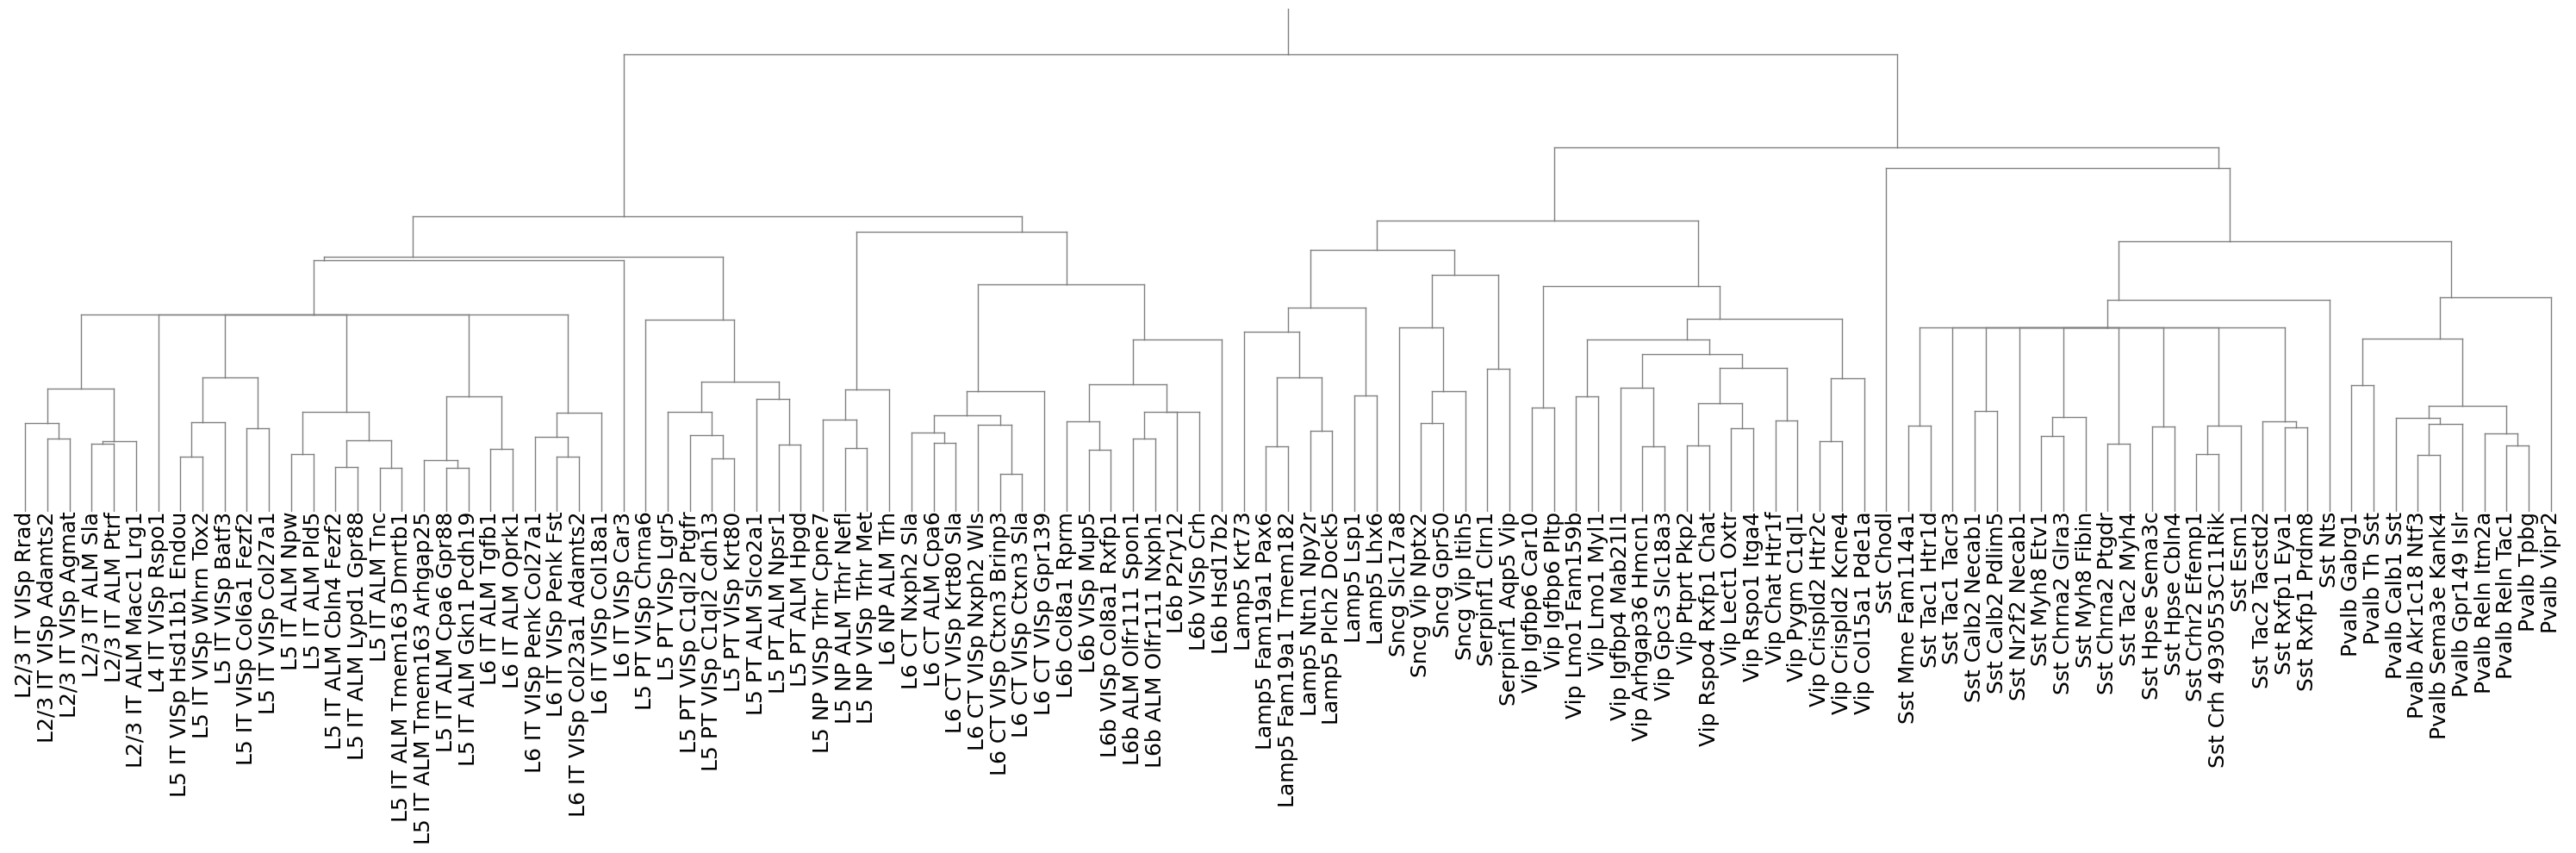

In [14]:
# Loading the taxonomy tree and ordering the clusters according to the tree
htree_file = config[dataset]['data_path'] / config[dataset]['htree_file']
data['cluster'] = np.array([c.strip() for c in data['cluster']])
cats_ttypes = np.unique(data['cluster'])
C_ttypes = len(cats_ttypes)
merged_cells_labels, treeobj, _ = get_merged_types(htree_file=htree_file, cells_labels=data['cluster'], num_classes=1)

cluster_ids = []
for i, s in enumerate(treeobj.child):
    s = s.strip()
    if (cats_ttypes == s).any():
        cluster_id = list(cats_ttypes).index(s)
        cluster_ids.append(cluster_id)
        
cats_ttypes_sorted = cats_ttypes[cluster_ids]

inds_ttypes_sorted = []
for s in cats_ttypes_sorted:
    inds_ttypes_sorted.append(list(cats_ttypes).index(s))
inds_ttypes_sorted = np.array(inds_ttypes_sorted)

# Plotting the taxonomy tree
treeobj.plot(figsize=[30,10], txtleafonly=True, skeletononly=False, fontsize=18, skeletoncol='gray')

In [15]:
# Assign colors to each cell type according to the taxonomy
color_ord_T = treeobj.col[treeobj.isleaf]
color_T = treeobj.col[treeobj.isleaf]
data['cluster_color'] = np.array([color_ord_T[0]]*len(data['cluster']))
for i_type, ttype in enumerate(cats_ttypes):
    idx1 = np.where(data['cluster'] == ttype)[0]
    idx2 = np.where(cats_ttypes_sorted == ttype)[0][0]
    data['cluster_color'][idx1] = color_ord_T[idx2]
    color_T[i_type] = color_ord_T[idx2]

In [16]:
outcome = summarize_inference(cplMixVAE, selected_model, all_loader)
category_vs_class = np.zeros((n_arm, data['n_type'], n_categories))

for a in range(A):
    label_predict = []
    for d in range(len(data['cluster_id'])):
        z_cat = np.squeeze(outcome['c_prob'][a][d, :])
        category_vs_class[a, int(data['cluster_id'][d] - 1), np.argmax(z_cat)] += 1
cT_vs_cT = category_vs_class[:, :, outcome['nprune_indx']]

Model /cpl_mixVAE_model_before_pruning_A3_2024-09-02-21-27-30.pth


/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/cpl_mixvae.py:324: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_file = torch.load(tr

#### t-types vs. MMIDAS categories

/tmp/ipykernel_289328/3855796593.py:48: FutureWarning: compute_consensus() is unstable
  pm, cat_inds = compute_consensus(cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted))
/tmp/ipykernel_289328/3855796593.py:49: FutureWarning: plot_consensus() is unstable
  plot_consensus(normalize_consensus(pm), outcome['nprune_indx'][cat_inds], cats_ttypes_sorted, color_ord_T, ((a, A, None), ('ttypes', 'ttypes', None)), saving_folder)
  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:26<00:00,  4.39it/s]
/tmp/ipykernel_289328/3855796593.py:48: FutureWarning: compute_consensus() is unstable
  pm, cat_inds = compute_consensus(cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted))
/tmp/ipykernel_289328/3855796593.py:49: FutureWarning: plot_consensus() is unstable
  plot_consensus(normalize_consensus(pm), outcome['nprune_indx'][cat_inds], cats_ttypes_sorted, color_ord_T, ((a, A, None), ('ttypes', 'ttypes', None)), saving_folder)
100%|██████████| 115/115 [00:26<00:00,  4.41it/s]
/tmp/ipykernel_289328/3855796593.py:48: FutureWarning: compute_consensus() is unstable
  pm, cat_inds = compute_consensus(cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted))
/tmp/ipykernel_289328/3855796593.py:49: FutureWarning: plot_consensus() is unstable
  plot_consensus(normalize_consensus(pm), outcome['nprune_indx'][cat_inds], cats_ttypes_sorted, color_ord_T, ((a, A, None), ('ttypes', 'ttypes', None)), saving_folder)
100%|██████████| 115/115 [00:2

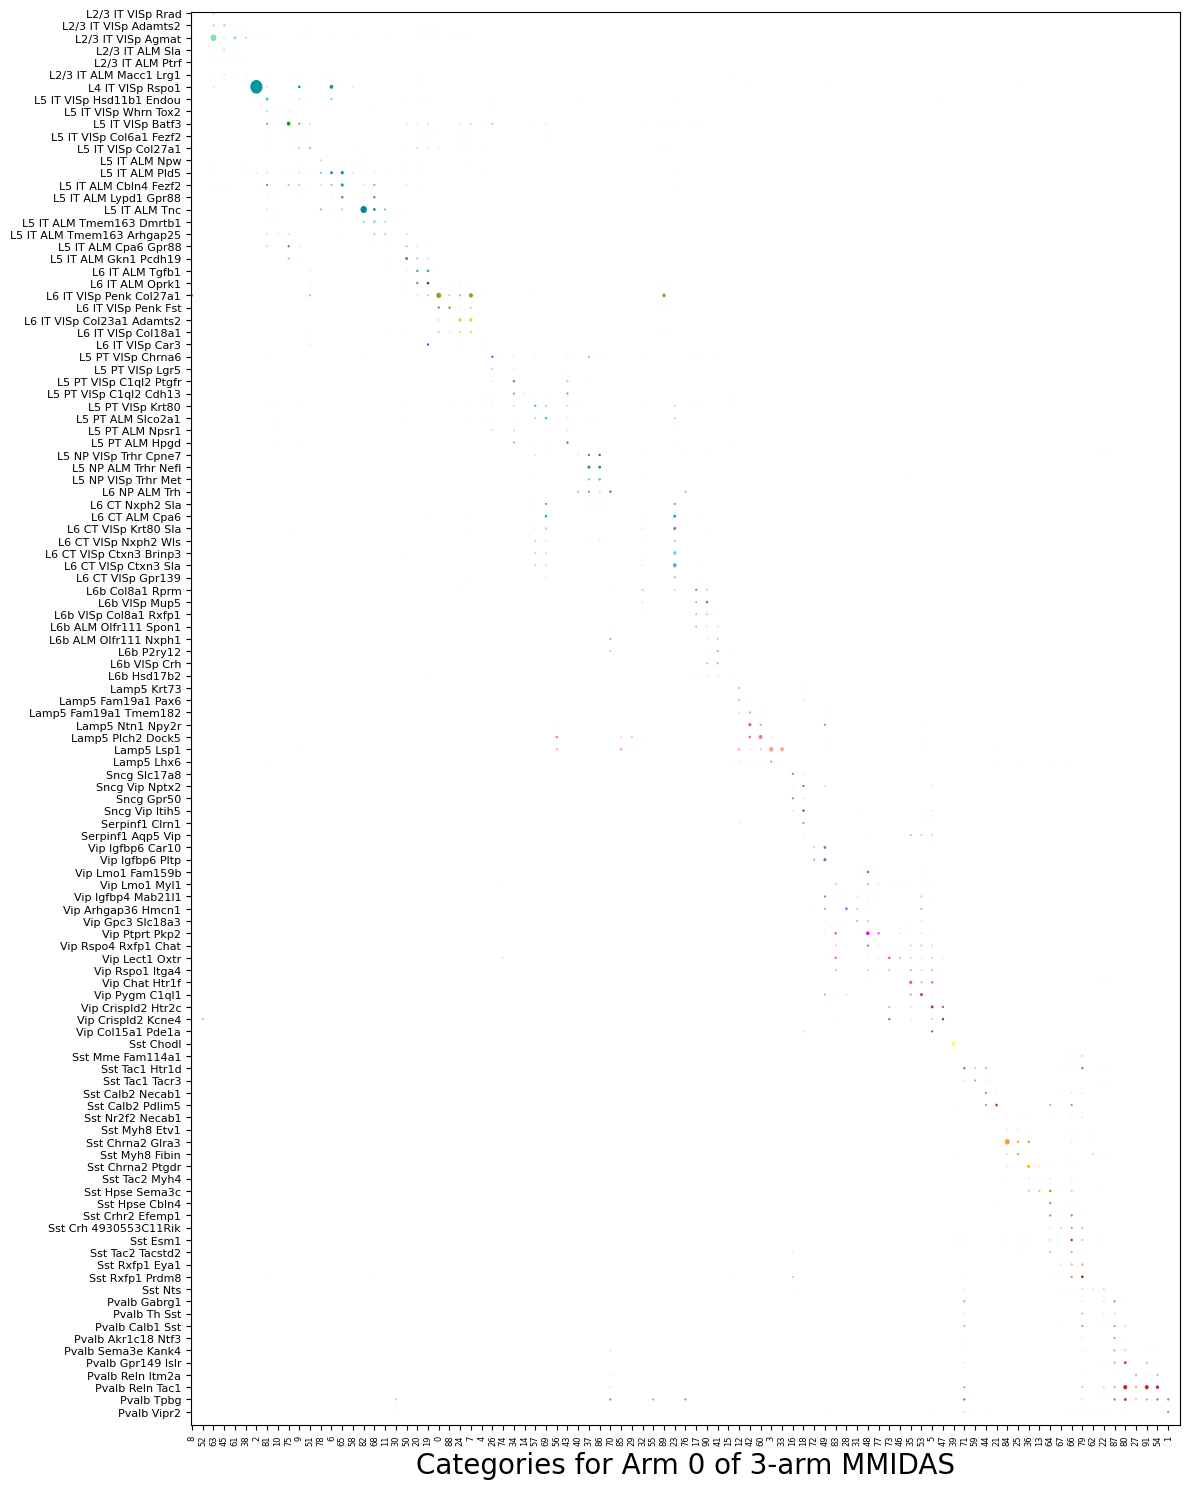

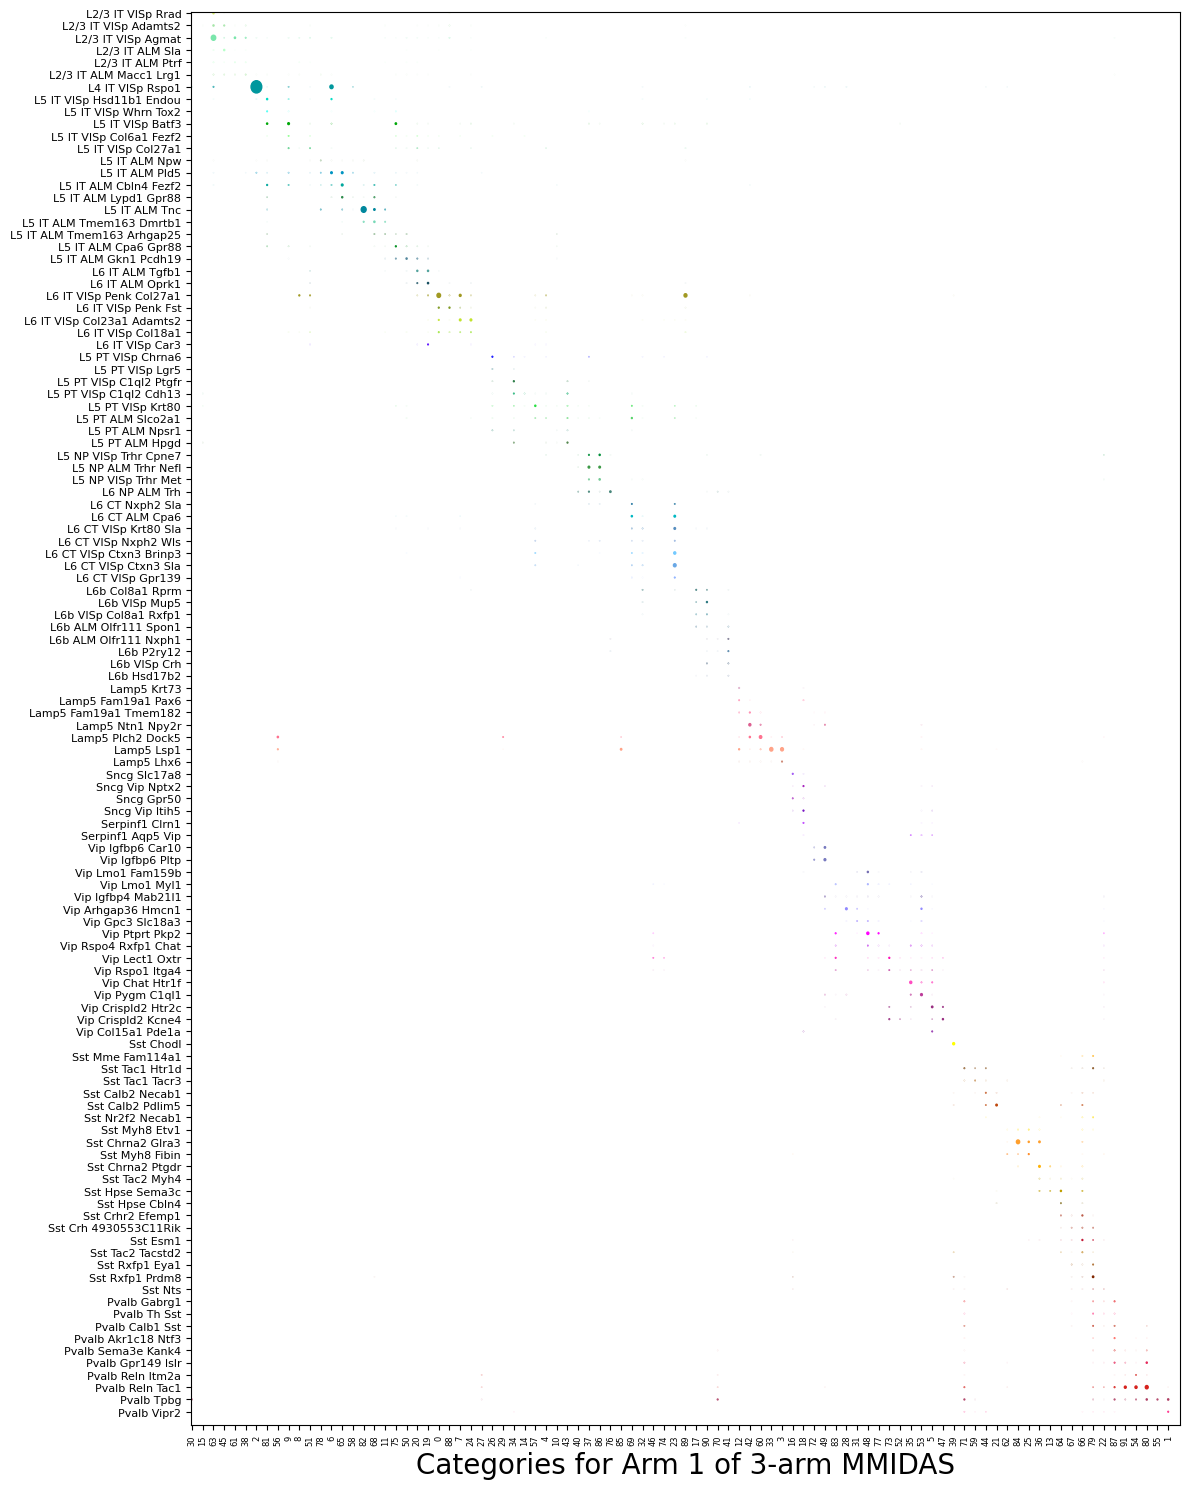

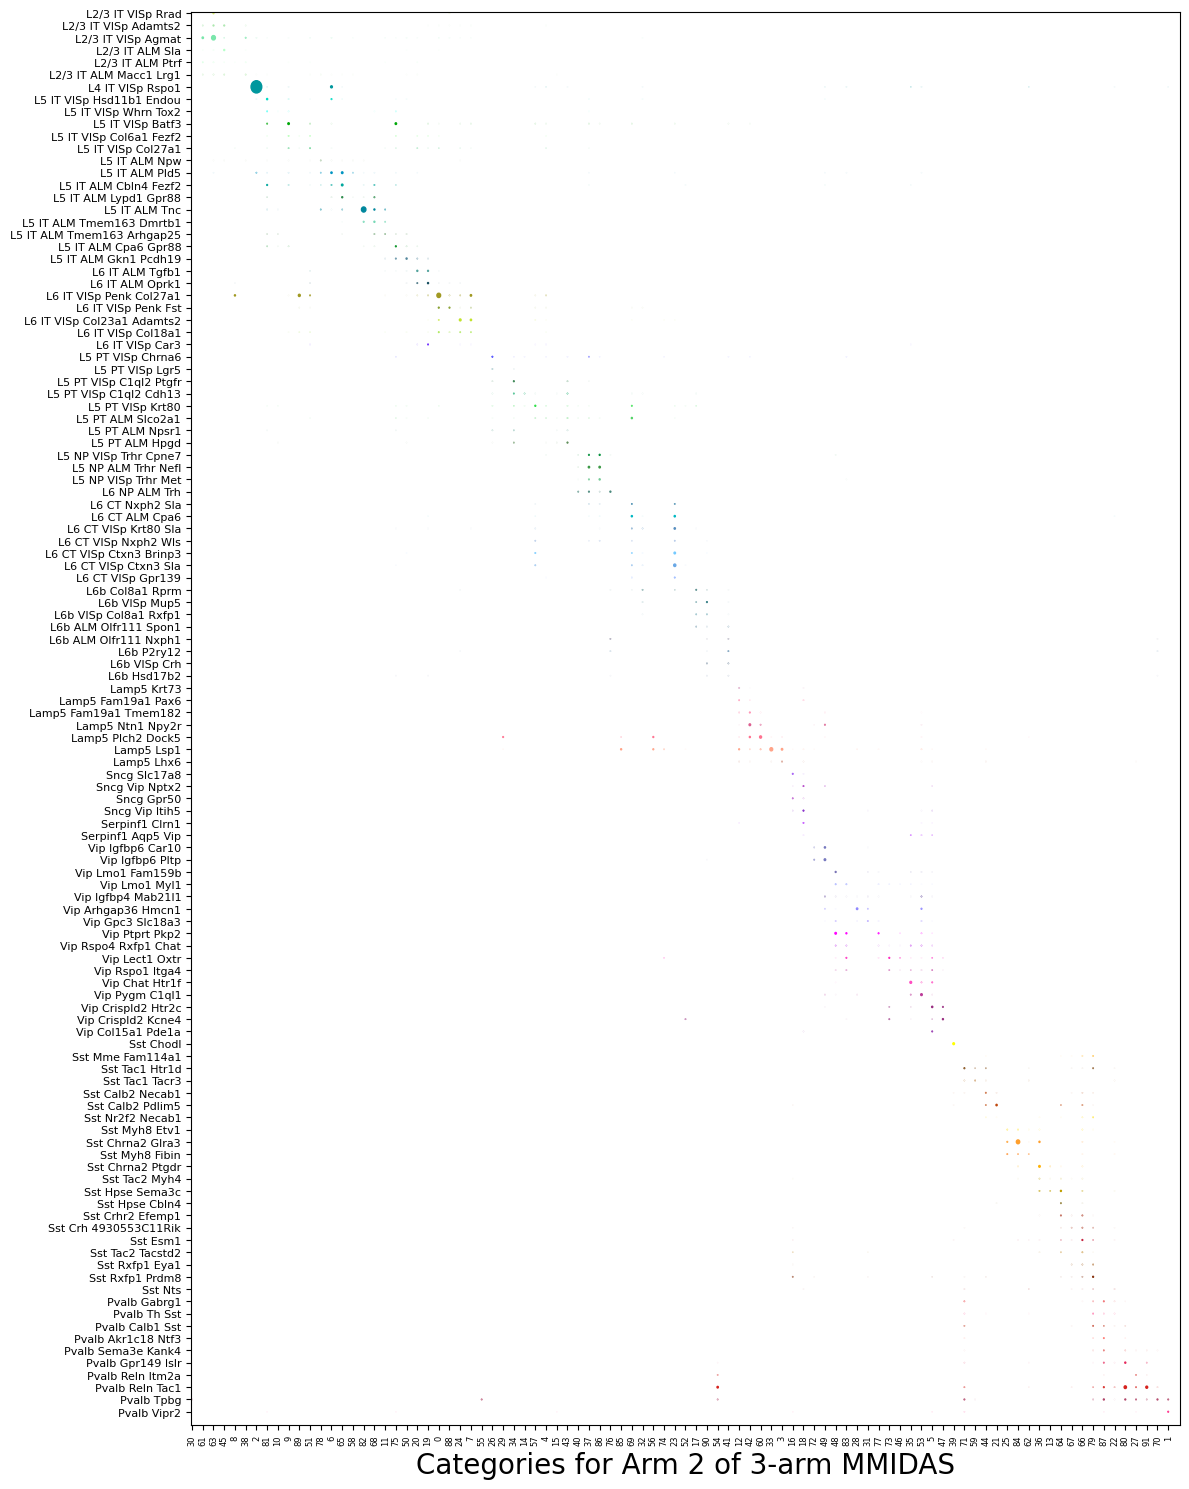

In [17]:
PerformanceMatrix = np.ndarray
ConsensusMatrix = np.ndarray

def rev(x: np.ndarray) -> np.ndarray:
    return x[::-1]

@unstable
def compute_consensus(pm: np.ndarray, target_dim: int) -> ConsensusMatrix:
    C = pm.shape[-1]

    cat_inds = linear_sum_assignment(-pm)[1]
    sort_idx = np.vstack([rev(np.argsort(pm[c_t])) for c_t in range(target_dim)]).astype(int)
    max_c_ind = -1 * np.ones(C)
    if C > target_dim:
        for c in filter(lambda c: c not in sort_idx[:,0], range(C)):
            col = np.argmax(pm[:, c].astype(int))
            find_indx = np.where(sort_idx[col, 0] == sort_idx[:,0])[0][0]
            max_c_ind[find_indx+1] = c
        max_c_ind[max_c_ind == -1] = sort_idx[:,0]
        cat_inds = max_c_ind.astype(int)
    return pm[:, cat_inds], cat_inds

def normalize_consensus(pm: np.ndarray) -> ConsensusMatrix:
    return pm / np.max(pm) / 2

@unstable
def plot_consensus(cm: np.ndarray, xticks, yticks, colors, axes: tuple[tuple[Arm, Arms, Optional[Run]], tuple[Arm, Arms, Optional[Run]]], savedir: Optional[str]) -> None:
    C_targets = cm.shape[0]
    C = cm.shape[1]

    fig, axs = plt.subplots(1, 1, figsize=(12, 15), dpi=100)
    for c_t in trange(C_targets):
        for c in range(C):
            axs.add_patch(plt.Circle(np.array([c, c_t]), radius=(cm[c_t, c]), color=colors[c_t]))
    axs.set_xlim([-.1, C + .1])
    axs.set_ylim([-.1, C_targets + 0.1])
    axs.invert_yaxis()
    axs.set_xlabel(f"Categories for {get_axis(axes[0])}", fontsize=20)
    axs.set_xticks(np.arange(C))
    axs.set_xticklabels(xticks, fontsize=6, rotation=90)
    axs.set_yticks(np.arange(C_targets))
    axs.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + f'/Taxonomy_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}.png', dpi=300)
    plt.show()

for a in range(A):
    pm, cat_inds = compute_consensus(cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted))
    plot_consensus(normalize_consensus(pm), outcome['nprune_indx'][cat_inds], cats_ttypes_sorted, color_ord_T, ((a, A, None), ('ttypes', 'ttypes', None)), saving_folder)

#### Mutual Information between t-types and MMIDAS categories

In [18]:
@unstable
def compute_mi(probs: np.ndarray, targets: np.ndarray) -> MI:
    C_pred = probs.shape[-1]
    C_target = targets.shape[-1]
    
    preds = np.argmax(probs, axis=-1)
    mi = np.zeros((C_target, C_pred))
    for c_p in trange(C_pred):
        for c_t in range(C_target):
            mi[c_t, c_p] = adjusted_mutual_info_score(targets[:, c_t], (preds == c_p).astype(int))
    return mi

def normalize_mi(mi: np.ndarray) -> np.ndarray:
    return normalize(mi, axis=1, norm='l1')

def plot_mi(mi: np.ndarray, axes: tuple[tuple[Arm, Arms], tuple[Arm, Arms]], xticks, yticks, savedir: Optional[str]) -> None:
    _, col_inds = linear_sum_assignment(-mi)

    fig, ax = plt.subplots(1, 1, figsize=(12, 13), dpi=100)
    sns.set_theme(font_scale=1.)
    sns.heatmap(mi[:, col_inds], xticklabels=xticks[col_inds], yticklabels=yticks, vmin=0, vmax=1, ax=ax, cbar_kws={'shrink': 1}) # pay attention to xticklabels
    ax.set_xlabel(get_axis(axes[0]), fontsize=20)
    ax.set_xticks([])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel(get_axis(axes[1]), fontsize=20)
    ax.set_yticks(np.arange(len(yticks)))
    ax.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + '/MI.png', dpi=300) # TODO
    plt.show()

for a in range(A):
    plot_mi(normalize_mi(compute_mi(outcome['c_prob'][a], data['c_onehot']))[inds_ttypes_sorted, :],
            ((a, A), ('ttypes', 'ttypes')),
            outcome['nprune_indx'], # pruning mask
            cats_ttypes_sorted, 
            saving_folder)

/tmp/ipykernel_289328/345527867.py:34: FutureWarning: compute_mi() is unstable
  plot_mi(normalize_mi(compute_mi(outcome['c_prob'][a], data['c_onehot']))[inds_ttypes_sorted, :],
 80%|████████  | 74/92 [01:12<00:17,  1.01it/s]


KeyboardInterrupt: 

In [48]:
def plot_state():
    raise NotImplementedError
    _, data_index = all_loader.dataset.tensors
    data_index = data_index.numpy().astype(int)

    for arm in range(n_arm):
        print(arm)
        plt.close('all')
        fig = plt.figure(figsize=(5, 5))
        m_size = 3
        alp = .5
        fontsize = 18

        sns.set_theme()
        sns.set(rc={'axes.facecolor':'whitesmoke'})

        if state_dim== 1:
            axs = fig.add_subplot(1, 1, 1)
            axs.hist(outcome['state_mu'][arm][:, 0], 
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(f'T_s_{0}')
        elif state_dim == 2:
            axs = fig.add_subplot(1,1,1)
            axs.scatter(outcome['state_mu'][arm][:, 0], outcome['state_mu'][arm][:, 1],
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(r'$s_{T_1}$', fontsize=fontsize)
            axs.set_ylabel(r'$s_{T_2}$', fontsize=fontsize)
            axs.xaxis.set_tick_params(labelsize=10)
            axs.yaxis.set_tick_params(labelsize=10)
        elif state_dim == 3:
            axs = fig.add_subplot(1,1,1, projection='3d')
            axs.scatter(outcome['state_mu'][arm][:, 0],
                    outcome['state_mu'][arm][:, 1],
                    outcome['state_mu'][arm][:, 2],
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(f'T_s_{0}')
            axs.set_ylabel(f'T_s_{1}')
            axs.set_zlabel(f'T_s_{2}')

        axs.set_ylim([-2.5, 3])
        axs.set_xlim([-2.5, 2.5])
        axs.set_title(f'Continuous Representation (arm {arm+1})', fontsize=18, pad=15)
        axs.grid(False)
        fig.tight_layout()
        plt.savefig(saving_folder + f'/state_mu_K_{model_order}_arm_{arm}.png', dpi=600)
        plt.show()